# Automatsko vodjenje objekata u prostoru

Autor: Djordje Marjanovic

## Zadatak 1

Analizirati primenu metoda paralelnog vodjenja u dve tacke u vertikalnoj 
ravni za sledeci scenario:

Cilj je letelica i nalazi se u pocetku na poziciji x = 5000m, y = 2500m. 
Krece se brzinom 200m/s. Pocetni ugao elevacije je 0. Od pocetnog trenutka 
vrsi manevar od 1g na vise.

Vodjeni objekat je letelica koja se u pocetnom trenutku nalazi u 
koordinatnom pocetku. Brzina objekta je sve vreme 400 m/s. Pocetno usmerenje 
vektora brzine objekta je 20 stepeni.

Simulirati trajektoriju vodjenog objekta i cilja, odrediti krajnji promasaj i
 profil promene normalnog ubrzanja.

### Postavka

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ipywidgets import interact

### Cilj

In [2]:
def create_target(t):
    x0 = 5000
    y0 = 2500
    vx0 = 200
    ay0 = 1
    return (
        x0 + vx0 * t,
        y0 + ay0 * t ** 2 / 2,
        vx0 + 0 * t,
        ay0 * t
    )

### Upravljanje

In [12]:
def control(state, target_state, e0):
    x, y, vx, vy = state
    target_x, target_y, target_vx, target_vy = target_state
    
    R = np.array([target_x - x, target_y - y, 0])
    Vr = np.array([target_vx - vx, target_vy - vy, 0])
    
    acc = Vr
    acc = np.cross(R, acc)
    acc = np.cross(R, acc)
    acc = acc / np.linalg.norm(R) ** 3
    acc = acc * np.linalg.norm(Vr)
    
    acc_normal = np.array([vy, -vx, 0])
    acc_normal = acc_normal / np.linalg.norm(acc_normal)
    acc_normal = acc.dot(acc_normal)
    return acc_normal * 25

### Model letelice

In [13]:
target_x, target_y, target_vx, target_vy = create_target(0)
e0 = np.arctan2(target_y, target_x)

def model(t, state):
    acc_normal = control(state, create_target(t), e0)
    
    x, y, vx, vy = state
    acc_angle = np.arctan2(vy, vx) + np.pi / 2
    acc = {
        'x': acc_normal * np.cos(acc_angle),
        'y': acc_normal * np.sin(acc_angle)
    }
    
    return np.array([vx, vy, acc['x'], acc['y']])

### Simulacija

In [17]:
def end_event(t, state):
    x, y, vx, vy = state
    target_x, target_y, target_vx, target_vy = create_target(t)
    dist = np.sqrt((target_x - x) ** 2 + (target_y - y) ** 2)
    return dist - 50

end_event.terminal = True

t_max = 100
dt = 0.01
x0, y0 = 0, 0
v0 = 400
angle0 = 20 / 180 * np.pi
vx0, vy0 = v0 * np.cos(angle0), v0 * np.sin(angle0)
t = np.linspace(0, t_max, int(t_max / dt + 1))

solution = solve_ivp(
    model,
    (0, t_max),
    [0, 0, vx0, vy0],
    t_eval = t,
    events = end_event
)
t = solution.t

### Vizuelizacija

In [18]:
def plane_outline(x, y, vx, vy, scale = 100, c='k'):
    plane_top = np.array([
        [-2.2, -2.7, -2, -0.5, -1.2, 0.5, 1.2, 1.9, 2],
        [0, 1, 0.4, 0.4, 2.5, 0.4, 0.4, 0.2, 0]
    ]) * np.array([[1], [0.7]])
    plane_bottom = np.flip(plane_top * np.array([[1], [-1]]), axis = 1)
    plane = np.concatenate([plane_top, plane_bottom], axis = 1)
    angle = np.arctan2(vy, vx)
    plane = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ]).dot(plane) * scale
    plt.plot(plane[0, :] + x, plane[1, :] + y, c)


x, y, vx, vy = solution.y
target_x, target_y, target_vx, target_vy = create_target(t) 
dist = np.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)
closest_index = np.argmin(dist)

e = np.arctan2(target_y - y, target_x - x)

num_parallels = 20

@interact(time=(0.0, t_max))
def plot(time=0.0):
    index = np.argmin(np.abs(t - time))

    fig, ax = plt.subplots(figsize = (15, 15))

    for i in range(num_parallels):
        parallel_index = int(i * (len(t) - 1) / (num_parallels - 1))
        p = plt.plot(
            [x[parallel_index], target_x[parallel_index]],
            [y[parallel_index], target_y[parallel_index]],
            '--k',
            alpha = 0.5
        )

    plt.plot(x, y, alpha = 0.5, c='C0')
    plane_outline(x[index], y[index], vx[index], vy[index], c='C0')
    plt.plot([x[closest_index]], [y[closest_index]], '^', c='C0')

    plt.plot(target_x, target_y, alpha = 0.5, c='C1')
    plane_outline(
        target_x[index], 
        target_y[index], 
        target_vx[index], 
        target_vy[index],
        c='C1'
    )
    plt.plot([target_x[closest_index]], [target_y[closest_index]], 'v', c='C1')
    ax.set_aspect('equal')
    plt.show()


interactive(children=(FloatSlider(value=0.0, description='time', max=200.0), Output()), _dom_classes=('widget-…

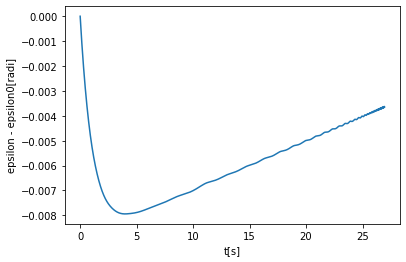

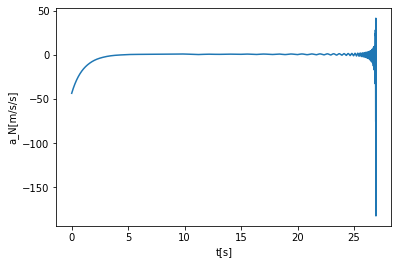

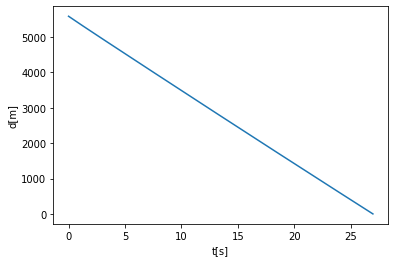

In [16]:
plt.plot(t, e - e0)
plt.xlabel('t[s]')
plt.ylabel('epsilon - epsilon0[radi]')
plt.show()

control_t = np.zeros((t.shape))
for i, time in enumerate(t):
    control_t[i] = control(solution.y[:, i], create_target(time), e0)

# plt.plot(t, control(solution.y, target.T, e0))
plt.plot(t, control_t)
plt.xlabel('t[s]')
plt.ylabel('a_N[m/s/s]')
plt.show()

plt.plot(t, dist)
plt.xlabel('t[s]')
plt.ylabel('d[m]')
plt.show()
